<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

In [32]:
#name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
name = 'regression_circle'

# Read the json info file
with open(f'../data/processed/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')


# Dynamical system

In [33]:
x_size = x_start.shape[1]
hidden_size = 20

iterations = 3
map = nn.Sequential(nn.Linear(x_size, hidden_size),
                    nn.ReLU(), 
                    nn.Linear(hidden_size, hidden_size), 
                    nn.ReLU(), 
                    nn.Linear(hidden_size, x_size))

In [34]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [35]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [36]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = start
        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)
            loss += criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 1.6849455833435059
Epoch 100, Batch 9, Loss 0.009687641635537148
Epoch 200, Batch 9, Loss 0.014885429292917252
Epoch 300, Batch 9, Loss 0.008888943120837212
Epoch 400, Batch 9, Loss 0.016459248960018158


# Training data

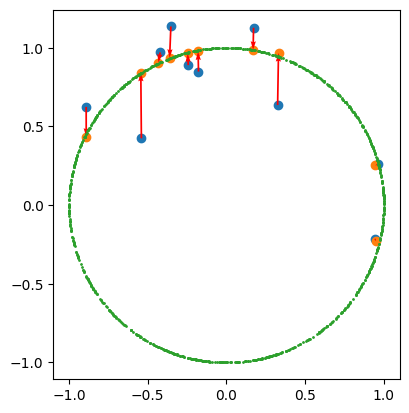

In [37]:
mapped_tensor = x_start_tensor
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()

# Testing data

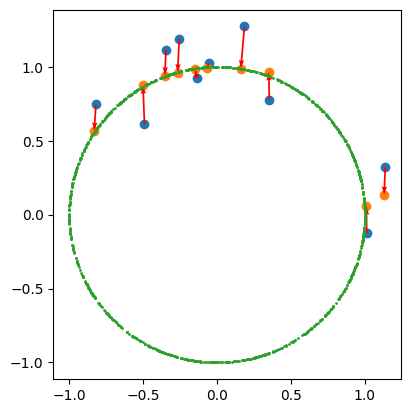

In [38]:
x_start_tensor_test = x_start_tensor+torch.rand_like(x_start_tensor)*0.2
mapped_tensor = x_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(x_start_tensor_test[:plot_points,0], 
            x_start_tensor_test[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor_test[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor_test[:plot_points,1]
plt.quiver(x_start_tensor_test[:plot_points,0], 
           x_start_tensor_test[:plot_points,1], 
           dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.gca().set_aspect('equal')
plt.show()